# Survival Multiarmed Bandits

## Comparing several algorithms through numerical experiments on the MAGB setting

The survival setting includes a budget $b$. From an initial budget $b_0$, the budget evolves with received rewards.

## Import dependencies:

In [2]:
#parameters
import_smab_from_localfolder = False
import_smab_from_github = False
export_files_from_colab = False

import sys

#verify if notebook is running from google colab
COLAB = 'google.colab' in sys.modules

#This option allows to export the graphics resulting from simulations when running on google colab
if COLAB and export_files_from_colab:
    from google.colab import files

#install
#!pip install -q ray

#smab packages locally
if (import_smab_from_localfolder):
    sys.path.append('../src/srl/mab/')

#smab packages on github
if (import_smab_from_github):
    !pip install git+https://github.com/fsperotto/srl.git

from srl.mab.arms import RandomArm, BernoulliArm
from srl.mab.policies import BasePolicy, RandomPolicy, FixedPolicy, EmpiricalMeansPolicy, EmpiricalSumPolicy, EpsilonGreedyPolicy, SoftMaxPolicy, UCB1Policy, BernKLUCBPolicy, ThompsonPolicy, BayesUCBPolicy, MaRaBPolicy
from srl.mab.policies import BanditGamblerPolicy, BanditGamblerUCBPolicy, AlarmedUCBPolicy, AlarmedBernKLUCBPolicy, AlarmedEpsilonGreedyPolicy, PositiveGamblerUCB
from srl.mab.simulator import SMAB

#Import Dependencies
import numpy as np
from numpy.random import binomial, randint, uniform, choice, rand, normal
from math import sqrt, log
from scipy.stats import beta
from scipy.integrate import quadrature as integral
import pandas as pd
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
from collections import Iterable
from IPython.display import display
import matplotlib.pyplot as plt
#import matplotlib.mlab as mlab
import datetime

%matplotlib inline
#%matplotlib notebook
#import pickle

#current date
date = datetime.datetime.now().strftime("%Y_%m_%d")

ImportError: cannot import name 'EmpiricalMeansPolicy' from 'srl.mab.policies' (d:\fperotto\sourcecode\srl\src\srl\mab\policies.py)

## Source Code:

In [3]:
# -*- coding: utf-8 -*-
"""Survival Multiarmed Bandits.

This module implements SMAB arms and methods.
"""

#Dependencies
#from typing import TypeVar, Generic
import numpy as np
import numpy.ma as ma
from numpy.random import binomial, randint, uniform, choice, rand
from math import sqrt, log
from scipy.stats import beta
#from scipy.integrate import quad as integral
#from scipy.integrate import fixed_quad as integral
from scipy.integrate import quadrature as integral
import pandas as pd
from numba import jit
from tqdm.notebook import tqdm
from collections import Iterable
#from IPython.display import display
import matplotlib.pyplot as plt
#import matplotlib.mlab as mlab
#import multiprocessing as mp
#from multiprocessing import Pool
#from functools import partial
#from concurrent.futures import ThreadPoolExecutor
import psutil
#import ray
import datetime
#%matplotlib inline
#%matplotlib notebook
#import pickle
#from google.colab import files

#type = TypeVar('T')

""" partially copied from SMPyBandits"""

class Domain():

    def __str__(self):
        return f"Domain ($r_min={self.r_min}, r_max={self.r_max}$)"

    def __init__(self, r_min=0.0, r_max=1.0):
        """ class for reward domain. 
            Arms always return values into the interval [0, 1].
            For budgeted problems, the domain is used for redimensioning r
        """
        #assert r_max >= r_min, "Error, the maximal reward must be greater than the minimal."  # DEBUG
        if r_max < r_min:
            print("SMAB warning: the maximal reward must be greater than the minimal; they were swaped.")
            r_max, rmin = r_min, r_max
        self.r_min = r_min  #: Lower values for rewards
        self.r_max = r_max  #: Higher values for rewards
        self.r_amp = r_max - r_min  #: Larger values for rewards
        self.r_0_1 = ((self.r_max==1.0) and (self.r_min==0.0))

################################################################################

class RandomArm():
    """ Base class for an arm class.
        return uniformly distributed random values between 0 and 1
    """
    def __str__(self):
        return f"Random Arm"

    def __init__(self):
        """ Base class for an arm class."""
        self.mean = 0.5

    def draw(self, shape=None):
        """ Draw a numpy array of random samples, of a certain shape. If shape is None, return a single sample"""
        return uniform(low=0.0, high=1.0, size=shape)

################################################################################

class BernoulliArm(RandomArm):
    """ Bernoulli distributed arm."""

    def __str__(self):
        return f"Bernoulli Arm ($p={self.p}$)"
    
    def __init__(self, p):
        """New arm."""
        super().__init__()
        #assert 0.0 <= p <= 1.0, "Error, the parameter probability for Bernoulli class has to be in [0, 1]."  # DEBUG
        if p > 1.0:
            print("SMAB warning: parameter p cannot be greater than 1.0; fixing it to 1.0")
            p = 1.0
        if p < 0.0:
            print("SMAB warning: parameter p cannot be negative; fixing it to 0.0")
            p = 0.0
        self.p = p  #: Parameter p for this Bernoulli arm
        self.mean = p

    # --- Random samples
    def draw(self, shape=None):
        """ Draw a numpy array of random samples, of a certain shape. If shape is None, return a single sample"""
        return binomial(1, self.p, size=shape)

################################################################################

class BasePolicy():
    """ Base class for any policy. """

    def __str__(self):
        return self.label
    
    def __init__(self, k, w=1, label=None):
        """ New policy."""
        # Parameters
        #assert k > 0, "Error, the number of arms must be a positive integer."  # DEBUG
        if k < 1:
            print("SMAB warning: parameter k must be a positive integer; fixing it to 2")
            k = 2
        if k < 0:
            print("SMAB warning: parameter w cannot be negative; fixing it to 0")
            w = 0
        self.k = int(k)  #: Number of Arms
        self.w = int(w)  #: if w>0, each arm must be played at least w times on the beginning (initial trials)
        # Internal state
        self.t = 0  #: Internal time-step
        self.n_i = np.zeros(self.k, dtype=int)  #: Number of pulls of each arm
        self.i_last = 0   #last pulled arm
        if label is not None:
            self.label = label
        else:
            self.label = "Base Policy"

    def reset(self):
        """ Start the game (fill pulls with 0)."""
        self.t = 0
        self.n_i.fill(0)
        self.i_last = 0

    def choose(self):
        if ( (self.w > 0) and (self.t < (self.k * self.w)) ):
          # play each arm w times, in order
          self.i_last = self.t % self.k
        else:
          # otherwise: undefined
          self.i_last = None
        return self.i_last

    def observe(self, r):
        """ Receive reward, increase t, pulls, and update."""
        #update internal state
        self._update(r)
        #evaluate
        self._evaluate()

    def _update(self, r):
        self.t += 1
        self.n_i[self.i_last] += 1

    def _evaluate(self):
        """ update utility after last observation """
        pass

################################################################################

class RandomPolicy(BasePolicy):
    """ Choose an arm uniformly at random. """

    def __init__(self, k, w=1, label=None):
        super().__init__(k, w=w, label=label)
        if label is None:
            self.label = "Random Policy"

    def choose(self):
        # base choice: verify mandatory initial rounds
        self.i_last = super().choose()
        # otherwise: random choice
        if self.i_last is None:
            # uniform choice among the arms
            self.i_last = randint(self.k)
        return self.i_last
        
    
################################################################################

class FixedPolicy(BasePolicy):
    """ Choose always the same arm. """

    def __init__(self, k, w=1, fixed_i=None, label=None):
        """ New fixed policy."""
        # Parameters
        super().__init__(k, w=w, label=label)
        if (fixed_i is None):
            #choose the fixed policy at random
            self.fixed_i = randint(self.k)
        else:
            #the fixed policy is given
            self.fixed_i = fixed_i
        if label is None:
            self.label = f"Fixed Policy ($i={self.fixed_i}$)"
            
    def choose(self):
        # base choice: verify mandatory initial rounds
        self.i_last = super().choose()
        # otherwise: random choice
        if self.i_last is None:
            # fixed choice
            self.i_last = self.fixed_i
        return self.i_last
        

################################################################################

class EmpiricalMeansPolicy(BasePolicy):
    """ Class that implements a generic index policy.
        by default, implements the empirical means method
        The naive Empirical Means policy for bounded bandits: like UCB but without a bias correction term. 
        Note that it is equal to UCBalpha with alpha=0, only quicker.
    """

    def __init__(self, k, v_ini=None, w=1, label=None):
        """ New generic index policy, based on empirical means. """
        super().__init__(k, w=w, label=label)
        self.s_i = np.full(k, 0.0)  #: cumulated rewards for each arm
        self.v_ini = v_ini  if  (v_ini is not None)  else  0.0   #: initial value (index or utility) for the arms
        self.v_i = np.full(k, v_ini)  #: value (index or utility) for each arm
        self.mu_i = np.full(k, None)  #: mean for each arm
        self.bests = np.arange(k)   #list of best arms (with equivalent highest utility), candidates
        if label is None:
            self.label = "Empirical Means"

    def reset(self):
        """ Initialize the policy for a new game."""
        super().reset()
        self.s_i.fill(0.0)
        self.v_i.fill(self.v_ini)
        self.mu_i.fill(None)
        self.bests = np.arange(self.k)

    def choose(self):
        r""" choose an arm with maximal index (uniformly at random):
        .. math:: A(t) \sim U(\arg\max_{1 \leq k \leq K} I_k(t)).
        .. note:: In almost all cases, there is a unique arm with maximal index, so we loose a lot of time with this generic code, but I couldn't find a way to be more efficient without loosing generality.
        """
        # base choice: verify mandatory initial rounds
        self.i_last = super().choose()
        # otherwise: index choice
        if self.i_last is None:
          # Uniform choice among the best arms
          self.i_last = choice(self.bests)
        return self.i_last

    def observe(self, r):
        """ Receive reward, increase t, pulls, and update."""
        super().observe(r)   # update() and evaluate()
        #define bests
        self.bests = self._calc_bests()

    def _update(self, r):
        """ update estimated means after last observation """
        super()._update(r)
        self.s_i[self.i_last] += r
        self.mu_i[self.i_last] = self.s_i[self.i_last] / self.n_i[self.i_last]

    def _evaluate(self):
        """ update utility after last observation 
            in this case, the utility is the estimated mean
        """
        self.v_i[self.i_last] = self.mu_i[self.i_last]   # value corresponds to the empirical mean
        #self.v_i[i] = (v * ((n-1) / n)) + (r / n)

    def _calc_bests(self):
        """ define best arms - all with equivalent highest utility - then candidates """
        return np.flatnonzero(self.v_i == np.max(self.v_i))
    
################################################################################

class EmpiricalSumPolicy(EmpiricalMeansPolicy):
    r""" The empirical sum policy.
    - At every time step, the arm with max total sum is chosen. It is a possible greedy policy for zero centered reward domains.
    - Because arms in this module have rawards in [0, 1], the sum is shifted to [-0.5, +0.5]
    """

    def _evaluate(self):
        """ update utility after last observation 
            in this case, the utility is the sum
        """
        self.v_i[self.i_last] = self.s_i[self.i_last] - (self.n_i[self.i_last] / 2)   # value corresponds to the "centralized" current sum : [0, 1] shifted to [-0.5, +0.5]

################################################################################

class EpsilonGreedyPolicy(EmpiricalMeansPolicy):
    r""" The epsilon-greedy random policy.
    - At every time step, a fully uniform random exploration has probability :math:`\varepsilon(t)` to happen, otherwise an exploitation is done.
    """

    def __init__(self, k, v_ini=None, w=1, eps=0.1, label=None):
        super().__init__(k, v_ini=v_ini, w=w, label=label)
        #assert 0 <= eps <= 1, "Error: the 'epsilon' parameter for EpsilonGreedy class has to be in [0, 1]."  # DEBUG
        if eps > 1.0:
            print("SMAB warning: parameter epsilon cannot be greater than 1.0; fixing it to 1.0")
            eps = 1.0
        if eps < 0.0:
            print("SMAB warning: parameter epsilon cannot be negative; fixing it to 0.0")
            eps = 0.0
        self.eps = eps
        if label is None:
            self.label = "$\epsilon$-Greedy ($\epsilon=" + str(round(self.eps,2)) + "$)"

    ##alternative: randomize instant utilities
    #def _calc_bests(self):
    #    # Generate random number
    #    p = rand()
    #    """With a probability of epsilon, explore (uniform choice), otherwise exploit based on empirical mean rewards."""
    #    if p < self.eps: # Proba epsilon : explore
    #        return np.array([randint(self.k)])
    #    else:  # Proba 1 - epsilon : exploit
    #        return super()._calc_bests()

    def choose(self):
        """With a probability of epsilon, explore (uniform choice), otherwise exploit based on empirical mean rewards."""
        # base choice: verify mandatory initial rounds
        self.i_last = BasePolicy.choose(self)
        # otherwise:
        if self.i_last is None:
          # Generate random number
          rnd_t = rand()
          # Proba epsilon : explore
          if rnd_t < self.eps: 
            # uniform choice among the arms
            self.i_last = randint(self.k)
          # Proba 1 - epsilon : exploit
          else:
            self.i_last = super().choose()
        return self.i_last

################################################################################
        
class SoftMaxPolicy(EmpiricalMeansPolicy):
    r"""The Boltzmann , label=NoneExploration (Softmax) index policy, with a constant temperature :math:`\eta_t`.
    - Reference: [Algorithms for the multi-armed bandit problem, V.Kuleshov & D.Precup, JMLR, 2008, §2.1](http://www.cs.mcgill.ca/~vkules/bandits.pdf) and [Boltzmann Exploration Done Right, N.Cesa-Bianchi & C.Gentile & G.Lugosi & G.Neu, arXiv 2017](https://arxiv.org/pdf/1705.10257.pdf).
    - Very similar to Exp3 but uses a Boltzmann distribution.
      Reference: [Regret Analysis of Stochastic and Nonstochastic Multi-armed Bandit Problems, S.Bubeck & N.Cesa-Bianchi, §3.1](http://sbubeck.com/SurveyBCB12.pdf)
    """

    def __init__(self, k, v_ini=None, w=1, eta=None, label=None):
        super().__init__(k, v_ini=v_ini, w=w, label=label)
        #assert eta > 0, "Error: the temperature parameter for Softmax class has to be > 0."
        if (eta is not None) and (eta <= 0.0):
            print("SMAB warning: the temperature parameter for Softmax has to be positive; setting it to default.")
            eta = None
        if eta is None:  # Use a default value for the temperature
            eta = np.sqrt(np.log(k) / k)
        self.eta = eta
        if label is None:
            self.label = f"SoftMax ($eta={round(self.eta,2)}$)"

    def _evaluate(self):
        r"""Update the trusts probabilities according to the Softmax (ie Boltzmann) distribution on accumulated rewards, and with the temperature :math:`\eta_t`.
        .. math::
           \mathrm{trusts}'_k(t+1) &= \exp\left( \frac{X_k(t)}{\eta_t N_k(t)} \right) \\
           \mathrm{trusts}(t+1) &= \mathrm{trusts}'(t+1) / \sum_{k=1}^{K} \mathrm{trusts}'_k(t+1).
        If :math:`X_k(t) = \sum_{\sigma=1}^{t} 1(A(\sigma) = k) r_k(\sigma)` is the sum of rewards from arm k.
        """
        i = self.i_last
        n_i = self.n_i[i]
        s_i = self.s_i[i]
        eta = self.eta
        self.v_i[i] = np.exp(s_i / (eta * n_i))

    def choose(self):
        """random selection with softmax probabilities, thank to :func:`numpy.random.choice`."""
        # base choice: verify mandatory initial rounds
        self.i_last = BasePolicy.choose(self)
        # otherwise:
        if self.i_last is None:
          # pondered choice among the arms based on their normalize v_i
          s = np.sum(self.v_i)
          if s > 0:
            self.i_last = choice(self.k, p=(np.array(self.v_i/s,dtype='float64')))
          else:
            self.i_last = randint(self.k)
        return self.i_last

################################################################################

class UCB1Policy(EmpiricalMeansPolicy):

    def __init__(self, k, v_ini=None, w=1, label=None):
        super().__init__(k, v_ini=v_ini, w=w, label=label)
        if label is None:
            self.label = "UCB1"

    def _evaluate(self):
        r""" Compute the current index, at time t and after :math:`N_k(t)` pulls of arm k:
        .. math:: I_k(t) = \frac{X_k(t)}{N_k(t)} + \sqrt{\frac{2 \log(t)}{N_k(t)}}.
        """
        #calculate utility following UCB formula
        t = self.t
        #i = self.i_last
        for i in range(self.k): 
            n_i = self.n_i[i]
            mu_i = self.mu_i[i]
            if self.n_i[i] == 0:
                self.v_i[i] = float('+inf')
            else:
                self.v_i[i] = mu_i + sqrt((2 * log(t)) / n_i)


################################################################################

class BernKLUCBPolicy(EmpiricalMeansPolicy):

    def __init__(self, k, v_ini=None, w=1, label=None):
        super().__init__(k, v_ini=v_ini, w=w, label=label)
        if label is None:
            self.label = f"KL-UCB (Bern)"
                  
    #@jit
    def _klBern(self, x, y):
        r""" Kullback-Leibler divergence for Bernoulli distributions.
        .. math:: \mathrm{KL}(\mathcal{B}(x), \mathcal{B}(y)) = x \log(\frac{x}{y}) + (1-x) \log(\frac{1-x}{1-y}).
        """
        eps = 1e-15  #: Threshold value: everything in [0, 1] is truncated to [eps, 1 - eps]
        x = min(max(x, eps), 1 - eps)
        y = min(max(y, eps), 1 - eps)
        return x * log(x / y) + (1 - x) * log((1 - x) / (1 - y))

    #@jit
    def _klucbBern(self, x, d, precision=1e-6):
        """ KL-UCB index computation for Bernoulli distributions, using :func:`klucb`."""
        upperbound = min(1., self._klucbGauss(x, d, sig2x=0.25))  # variance 1/4 for [0,1] bounded distributions
        return self._klucb(x, d, upperbound, precision)

    #@jit
    def _klucbGauss(self, x, d, sig2x=0.25):
        """ KL-UCB index computation for Gaussian distributions.
        - Note that it does not require any search.
        .. warning:: it works only if the good variance constant is given.
        .. warning:: Using :class:`Policies.klUCB` (and variants) with :func:`klucbGauss` is equivalent to use :class:`Policies.UCB`, so prefer the simpler version.
        """
        return x + sqrt(abs(2 * sig2x * d))

    #@jit
    def _klucb(self, x, d, upperbound, precision=1e-6, lowerbound=float('-inf'), max_iterations=50):
        r""" The generic KL-UCB index computation.
        - ``x``: value of the cum reward,
        - ``d``: upper bound on the divergence,
        - ``kl``: the KL divergence to be used (:func:`klBern`, :func:`klGauss`, etc),
        - ``upperbound``, ``lowerbound=float('-inf')``: the known bound of the values ``x``,
        - ``precision=1e-6``: the threshold from where to stop the research,
        - ``max_iterations=50``: max number of iterations of the loop (safer to bound it to reduce time complexity).
        .. math::
            \mathrm{klucb}(x, d) \simeq \sup_{\mathrm{lowerbound} \leq y \leq \mathrm{upperbound}} \{ y : \mathrm{kl}(x, y) < d \}.
        .. note:: It uses a **bisection search**, and one call to ``kl`` for each step of the bisection search.
        For example, for :func:`klucbBern`, the two steps are to first compute an upperbound (as precise as possible) and the compute the kl-UCB index:
        >>> x, d = 0.9, 0.2   # mean x, exploration term d
        >>> upperbound = min(1., klucbGauss(x, d, sig2x=0.25))  # variance 1/4 for [0,1] bounded distributions
        """
        v = max(x, lowerbound)
        u = upperbound
        i = 0
        while ((i < max_iterations) and (u - v > precision)):
            i += 1
            m = (v + u) * 0.5
            if self._klBern(x, m) > d:
                u = m
            else:
                v = m
        return (v + u) * 0.5

    def _evaluate(self):
        r""" Compute the current index, at time t and after :math:`N_k(t)` pulls of arm k:
        .. math::
            \hat{\mu}_k(t) &= \frac{X_k(t)}{N_k(t)}, \\
            U_k(t) &= \sup\limits_{q \in [a, b]} \left\{ q : \mathrm{kl}(\hat{\mu}_k(t), q) \leq \frac{c \log(t)}{N_k(t)} \right\},\\
            I_k(t) &= U_k(t).
        If rewards are in :math:`[a, b]` (default to :math:`[0, 1]`) and :math:`\mathrm{kl}(x, y)` is the Kullback-Leibler divergence between two distributions of means x and y (see :mod:`Arms.kullback`),
        and c is the parameter (default to 1).
        """
        c = 1.0
        #tolerance = 1e-4
        t = self.t
        #i = self.i_last
        for i in range(self.k): 
            n_i = self.n_i[i]
            mu_i = self.mu_i[i]
            if n_i == 0:
                self.v_i[i] = float('+inf')
            else:
                self.v_i[i] = self._klucbBern(mu_i, c * log(t) / n_i)

################################################################################

class ThompsonPolicy(EmpiricalMeansPolicy):
    r"""The Thompson (Bayesian) index policy.
    - By default, it uses a Beta posterior (:class:`Policies.Posterior.Beta`), one by arm.
    - Prior is initially flat, i.e., :math:`a=\alpha_0=1` and :math:`b=\beta_0=1`.
    - Reference: [Thompson - Biometrika, 1933].
    """

    def __init__(self, k, v_ini=None, w=1, label=None):
        super().__init__(k, v_ini=v_ini, w=w, label=label)
        if label is None:
            self.label = "Thompson-Sampling (Beta)"
                  
    def _evaluate(self):
        r""" Compute the current index, at time t and after :math:`N_k(t)` pulls of arm k, giving :math:`S_k(t)` rewards of 1, by sampling from the Beta posterior:
        .. math::
            A(t) &\sim U(\arg\max_{1 \leq k \leq K} I_k(t)),\\
            I_k(t) &\sim \mathrm{Beta}(1 + \tilde{S_k}(t), 1 + \tilde{N_k}(t) - \tilde{S_k}(t)).
        """
        for i in range(self.k):
          alp = self.s_i[i] + 1
          bet = self.n_i[i] - self.s_i[i] + 1
          self.v_i[i] = beta.rvs(alp, bet)


################################################################################

class BayesUCBPolicy(EmpiricalMeansPolicy):
    """ The Bayes-UCB policy.
    - By default, it uses a Beta posterior (:class:`Policies.Posterior.Beta`), one by arm.
    -Reference: [Kaufmann, Cappé & Garivier - AISTATS, 2012].
    """

    def __init__(self, k, v_ini=None, w=1, label=None):
        super().__init__(k, v_ini=v_ini, w=w, label=label)
        if label is None:
            self.label = "Bayes-UCB (Beta)"
                  
    def _evaluate(self):
        r""" Compute the current index, at time t and after :math:`N_k(t)` pulls of arm k, giving :math:`S_k(t)` rewards of 1, by taking the :math:`1 - \frac{1}{t}` quantile from the Beta posterior:
        .. math:: I_k(t) = \mathrm{Quantile}\left(\mathrm{Beta}(1 + S_k(t), 1 + N_k(t) - S_k(t)), 1 - \frac{1}{t}\right).
        """
        #t = self.t
        #q = 1. - (1. / (1 + t))
        t = max(1.0, self.t)
        q = 1 - (1 / t)

        #i = self.i_last
        for i in range(self.k): 
            #q = 1. - (1. / (1 + self.n_i[i]))
            alp = self.s_i[i] + 1
            bet = self.n_i[i] - self.s_i[i] + 1
            self.v_i[i] = beta.ppf(q, alp, bet)

################################################################################

# class for the marab algorithm
class MaRaBPolicy(EmpiricalMeansPolicy):

    def __init__(self, k, v_ini=None, w=1, label=None, alpha=0.05, c=1e-6):
        super().__init__(k, v_ini=v_ini, w=w, label=label)
        self.alpha = alpha
        self.c = c
        self.reward_samples = [np.array([0.0]) for a in range(k)]
        if label is None:
            self.label = f"Empirical-MARAB ($\alpha={self.alpha}$)"
        
    def reset(self):
        super().reset()
        self.reward_samples = [np.array([0.0]) for a in range(self.k)]
                                       
    def _update(self, r):
        super()._update(r)
        self.reward_samples[self.i_last] = np.sort(np.append(self.reward_samples[self.i_last], [r]))
        
    def _evaluate(self):
        t = self.t
        #i = self.i_last
        for i in range(self.k): 
            # calculating empirical cvar
            e = np.ceil(self.alpha*self.n_i[i]).astype(int)
            empirical_cvar = self.reward_samples[i][:e].mean()
            # calculating lower confidence bound
            lcb = np.sqrt(np.log(np.ceil(self.alpha*t))/self.n_i[i])
            # adding score to scores list
            self.v_i[i] = empirical_cvar - self.c * lcb

################################################################################

class Budgeted:

    def __str__(self):
        return f"Budgeted ($k={self.k}, b_0={self.b_0}$)"
                  
    def __init__(self, k, d=None, b_0=None, w=1):
        if b_0 is None:
            b_0 = k
        self.b_0 = b_0  #ini budget
        self.w = w  #number of times each arm is tryied before impact budget
        self.d = d  if  (isinstance(d, Domain))  else  Domain()
        self.b = b_0   #budget
        self.s = 0.0   #total cumulated rewards
        
    def reset(self):
        self.b = self.b_0
        self.s = 0.0

    def _update(self, r):
        if self.t >= self.w * self.k :
          self.s += r
          self.b += r * self.d.r_amp + self.d.r_min

################################################################################


class AlarmedUCBPolicy(UCB1Policy, Budgeted):

    def __init__(self, k, v_ini=None, w=1, label=None, d=None, b_0=None, omega=1.0):
        UCB1Policy.__init__(self, k, v_ini=v_ini, w=w, label=label)
        Budgeted.__init__(self, k, d=d, b_0=b_0, w=w)
        self.omega = omega   #safety-critical warning threshold for budget level
        if label is None:
            self.label = f"Alarmed-UCB($\omega={self.omega}$)"

    def reset(self):
        UCB1Policy.reset(self)
        Budgeted.reset(self)

    def _update(self, r):
        UCB1Policy._update(self, r)
        Budgeted._update(self, r)

    def choose(self):
        # base choice: verify mandatory initial rounds
        BasePolicy.choose(self)
        # otherwise:
        if self.i_last is None:
            #low budget
            if (self.b <= self.omega): # and (np.max(self.v_i) > 0.0):
                EmpiricalMeansPolicy.choose(self)
            #sufficient budget
            else:
                UCB1Policy.choose(self)
        return self.i_last


class AlarmedBernKLUCBPolicy(BernKLUCBPolicy, Budgeted):

    def __init__(self, k, v_ini=None, w=1, label=None, d=None, b_0=None, omega=1.0):
        BernKLUCBPolicy.__init__(self, k, v_ini=v_ini, w=w, label=label)
        Budgeted.__init__(self, k, d=d, b_0=b_0, w=w)
        self.omega = omega   #safety-critical warning threshold for budget level
        if label is None:
            self.label = f"Alarmed-KL-UCB($\omega={self.omega}$)"

    def reset(self):
        BernKLUCBPolicy.reset(self)
        Budgeted.reset(self)

    def _update(self, r):
        BernKLUCBPolicy._update(self, r)
        Budgeted._update(self, r)

    def choose(self):
        # base choice: verify mandatory initial rounds
        BasePolicy.choose(self)
        # otherwise:
        if self.i_last is None:
            #low budget
            if (self.b <= self.omega): # and (np.max(self.v_i) > 0.0):
                EmpiricalMeansPolicy.choose(self)
            #sufficient budget
            else:
                BernKLUCBPolicy.choose(self)
        return self.i_last


class AlarmedEpsilonGreedyPolicy(EpsilonGreedyPolicy, Budgeted):

    def __init__(self, k, v_ini=None, w=1, label=None, d=None, b_0=None, omega=1.0, eps=0.9):
        EpsilonGreedyPolicy.__init__(self, k, v_ini=v_ini, w=w, label=label, eps=eps)
        Budgeted.__init__(self, k, d=d, b_0=b_0, w=w)
        self.omega = omega   #safety-critical warning threshold for budget level
        if label is None:
            self.label = "Alarmed-$\epsilon$-greedy($\epsilon=" + str(round(self.eps,2)) + "\omega=" + str(round(self.omega, 2)) + "$)"

    def reset(self):
        EpsilonGreedyPolicy.reset(self)
        Budgeted.reset(self)

    def _update(self, r):
        EpsilonGreedyPolicy._update(self, r)
        Budgeted._update(self, r)

    def choose(self):
        # base choice: verify mandatory initial rounds
        BasePolicy.choose(self)
        # otherwise:
        if self.i_last is None:
            #low budget
            if (self.b <= self.omega): # and (np.max(self.v_i) > 0.0):
                EmpiricalMeansPolicy.choose(self)
            #sufficient budget
            else:
                EpsilonGreedyPolicy.choose(self)
        return self.i_last

    
#####################################################


class BanditGamblerPolicy(EmpiricalMeansPolicy, Budgeted):

    def __init__(self, k, v_ini=None, w=1, label=None, d=None, b_0=None):
        #super().__init__(k, v_ini=v_ini, w=w, d=d, b_0=b_0)
        EmpiricalMeansPolicy.__init__(self, k, v_ini=v_ini, w=w, label=label)
        Budgeted.__init__(self, k, d=d, b_0=b_0, w=w)
        if label is None:
            self.label = "Bandit-Gambler"

    #@jit
    def ruin_estimated_prob(self, i):
        n_i = self.n_i[i]
        x_i = self.s_i[i]
        y_i = n_i - self.s_i[i]
        b = max(1.0, self.b)
        return beta.cdf(0.5, x_i+1, y_i+1) + integral(lambda p, x, y, b : ((1-p)/p)**b * beta.pdf(p, x+1, y+1), 0.5, 1.0, (x_i, y_i, b))[0]

    def surv_estimated_prob(self, i):
        n_i = self.n_i[i]
        x_i = self.s_i[i]
        y_i = n_i - x_i
        b = max(1.0, self.b)
        return integral(lambda p, x, y, b : (1-((1-p)/p)**b) * beta.pdf(p, x+1, y+1), 0.5, 1.0, (x_i, y_i, b))[0]

    def reset(self):
        #super().reset()
        EmpiricalMeansPolicy.reset(self)
        Budgeted.reset(self)

    def _update(self, r):
        #super()._update(r)
        EmpiricalMeansPolicy._update(self, r)
        Budgeted._update(self, r)

    def _evaluate(self):
        i = self.i_last
        #self.v_i[i] = 1.0 - self.ruin_estimated_prob(i)
        self.v_i[i] = self.surv_estimated_prob(i)


################################################################################

class BanditGamblerUCBPolicy(BanditGamblerPolicy):

    def __init__(self, k, v_ini=None, w=1, label=None, d=None, b_0=None):
        super().__init__(k, v_ini=v_ini, w=w, label=label)
        Budgeted.__init__(self, k, d=d, b_0=b_0, w=w)
        if label is None:
            self.label = "Bandit-Gambler-UCB"

    def _evaluate(self):
        for i in range(self.k):
            self.v_i[i] = 1.0 - self.ruin_estimated_prob(i)
            
    def ruin_estimated_prob(self, i):
        b = max(1.0, self.b)
        factor = np.log(self.t)/self.t
        n_i = self.n_i[i]
        x_i = self.s_i[i]
        y_i = n_i - self.s_i[i]
        return beta.cdf(0.5, x_i+1, y_i+1) + integral(lambda p, x, y, b : ((1-p)/p)**b * beta.pdf(p, x*factor+1, y*factor+1), 0.5, 1.0, (x_i, y_i, b))[0]

################################################################################

class PositiveGamblerUCB(EmpiricalMeansPolicy, Budgeted):

    def __init__(self, k, v_ini=None, w=1, label=None, d=None, b_0=None):
        #super().__init__(k, v_ini=v_ini, w=w, d=d, b_0=b_0)
        EmpiricalMeansPolicy.__init__(self, k, v_ini=v_ini, w=w, label=label)
        Budgeted.__init__(self, k, d=d, b_0=b_0, w=w)
        if label is None:
            self.label = "Positive-Gambler"

    def reset(self):
        #super().reset()
        EmpiricalMeansPolicy.reset(self)
        Budgeted.reset(self)

    def _update(self, r):
        #super()._update(r)
        EmpiricalMeansPolicy._update(self, r)
        Budgeted._update(self, r)

    def _evaluate(self):
        t = self.t
        b = max(1.0, self.b)
        for i in range(self.k):
            n_i = self.n_i[i]
            mu_i = self.mu_i[i]
            x_i = self.s_i[i]
            y_i = n_i - self.s_i[i]
            if self.n_i[i] == 0:
                self.v_i[i] = float('+inf')
            else:
                self.v_i[i] = 1 - beta.cdf(0.5, x_i+1, y_i+1) + sqrt((2 * log(b)) / n_i)

################################################################################

class BayesUCBGamblerPolicy(BayesUCBPolicy, Budgeted):

    def __init__(self, k, v_ini=None, w=1, label=None, d=None, b_0=None):
        BayesUCBPolicy.__init__(self, k, v_ini=v_ini, w=w, label=label)
        Budgeted.__init__(self, k, d=d, b_0=b_0, w=w)
        if label is None:
            self.label = "Bayes-UCB-Gambler (b instead of t)"

    def reset(self):
        #super().reset()
        BayesUCBPolicy.reset(self)
        Budgeted.reset(self)

    def _update(self, r):
        #super()._update(r)
        BayesUCBPolicy._update(self, r)
        Budgeted._update(self, r)

    def _evaluate(self):
        r""" Compute the current index, at time t and after :math:`N_k(t)` pulls of arm k, giving :math:`S_k(t)` rewards of 1, by taking the :math:`1 - \frac{1}{t}` quantile from the Beta posterior:
        .. math:: I_k(t) = \mathrm{Quantile}\left(\mathrm{Beta}(1 + S_k(t), 1 + N_k(t) - S_k(t)), 1 - \frac{1}{t}\right).
        """

        t = max(1.0, self.t)
        b = max(1.0, self.b)
        q = 1 - (1 / b)   #changed t by b

        for i in range(self.k):
          n_i = self.n_i[i]
          x_i = self.s_i[i]
          y_i = n_i - x_i

          #beta quantile (inverse of cdf)
          #beta.ppf(prob,alpha,beta)
          self.v_i[i] = beta.ppf(q, x_i+1, y_i+1)


################################################################################


class SMAB():
    """ Base survival MAB process. """

    def __init__(self, A, G, h, b_0, d=None, n=1, w=1, run=False, save_only_means=True):
        """
         A : List of Arms
         G : List of Algorithms
         h : max time-horizon
         d : rewards domain
         n : number of repetitions
         w : number of times each arm must be played at beginning
         b_0 : initial budget
        """

        #domain of rewards ( by default on [0, 1] )
        self.d = d  if  isinstance(d, Domain)  else  Domain()

        #time-horizon (0, 1 ... t ... h)
        self.h = h   #time-horizon
        self.T = range(self.h)          #range for time (0 ... h-1)
        self.T1 = range(1, self.h+1)    #range for time (1 ... h)
        self.T01 = range(0, self.h+1)   #range for time (0, 1 ... h)

        #arms (1 ... i ... k)
        self.A = A if isinstance(A, Iterable) else [A]

        #number of arms
        self.k = len(self.A)
        self.K = range(self.k)          #range for arms (0 ... k-1)
        self.K1 = range(1,self.k+1)     #range for arms (1 ... k)

        #arms properties
        self.mu_a = np.array([a.mean for a in A]) * self.d.r_amp + self.d.r_min     #means
        self.a_star = np.argmax(self.mu_a)             #best arm index
        self.a_worst = np.argmin(self.mu_a)            #worst arm index
        self.mu_star = np.max(self.mu_a)               #best mean
        self.mu_worst = np.min(self.mu_a)              #worst mean

        #budget
        self.b_0 = b_0   
        
        #algorithms (1 ... g ... m)
        self.G = G if isinstance(G, Iterable) else [G]
        self.m = len(self.G)

        #repetitions (1 ... j ... n)
        self.n = n

        #window
        self.w = w

        #run
        if run:
            self.run()


    def run(self, tqdm_desc_it="iterations", tqdm_desc_alg="algorithms", tqdm_desc_rep="repetitions", tqdm_leave=False, tqdm_disable=False, prev_draw=True, num_threads=1, smooth_window=None):

        #time-horizon (1 ... t ... h)
        #arms (1 ... i ... k)
        #repetitions (1 ... j ... n)
        #algorithms (1 ... g ... m)

        num_cpus = psutil.cpu_count(logical=False)        
        
        # Initialize Rewards and History of selected Actions (3d matrices [t x g x i])
        X = np.zeros((self.n, self.m, self.h), dtype=float)  #successes
        H = np.full((self.n, self.m, self.h), -1, dtype=int) #history of actions

        # Draw for every arm all repetitions
        if prev_draw:
            #X_i_t_j = np.array([arm.draw((self.h, self.n)) for arm in self.A])
            X_t_j = rand(self.h, self.n)     #luck is the same for every arm in a same round and repetition
            #X_i_t_j = np.array([ np.where(X_t_j <= arm.mean, 1, 0)    for arm in self.A])

        # For each repetition
        #for j in tqdm(range(self.n), desc=tqdm_desc_rep, leave=(tqdm_leave and self.m == 1), disable=(tqdm_disable or self.n == 1)):
        #for j in tqdm(range(self.n), desc=tqdm_desc_rep, leave=tqdm_leave, disable=(tqdm_disable or self.n == 1)):
        for j in tqdm(range(self.n)):

            # For each algorithm
            #for g, alg in enumerate(tqdm(self.G, desc=tqdm_desc_alg, leave=tqdm_leave, disable=(tqdm_disable or self.m == 1))):
            for g, alg in enumerate(self.G):

                # Initialize
                alg.reset()

                # Loop on time
                #for t in tqdm(self.T, desc=tqdm_desc_it, leave=tqdm_leave, disable=(tqdm_disable or self.n > 1 or self.m > 1) ):
                for t in self.T:
                    # The algorithm chooses the arm to play
                    i = alg.choose()
                    # The arm played gives reward
                    if prev_draw:
                        if X_t_j[t,j] <= self.A[i].mean:
                          x = 1   
                        else: 
                          x = 0
                        #x = X_i_t_j[i, t, j]
                    else:
                        x = self.A[i].draw()
                    # The reward is returned to the algorithm
                    alg.observe(x)
                    # Save both
                    H[j, g, t] = i
                    X[j, g, t] = x

        #Translate Rewards following Domain
        R = X * self.d.r_amp + self.d.r_min
        R[:,:,:self.w*self.k] = 0

        #actions history, with initial action index being 1, not 0
        H1 = H+1

        #actions map (bool 4d matrix)
        H_a = np.array([[[[True if (H[j,g,t]==i) else False for t in self.T] for i in self.K] for g in range(self.m)] for j in range(self.n)], dtype='bool')

        #progressive actions count (int 4d matrix [t x j x i x a])
        N_a = np.cumsum(H_a, axis=3)

        #averaged progressive actions count (float 3d matrix [t x j x a]) #averaged over repetitions
        self.MN_a = np.mean(N_a, axis=0)

        #progressive actions frequency (float 4d matrix [t x j x i x a])
        F_a = N_a / self.T1

        #averaged progressive actions frequency (float 3d matrix [t x j x a]) #averaged over repetitions
        self.MF_a = np.mean(F_a, axis=0)

        #final arm pull count (int 3d matrix [j x i x a])
        #n_a = N_a[:,:,:,self.h-1]
        n_a = N_a[:,:,:,-1]

        #averaged final arm pull count (float 2d matrix [j x a]) #averaged over repetitions
        self.mn_a = np.mean(n_a, axis=0)

        #final arm pull frequency (float 3d matrix [j x i x a])
        f_a = F_a[:,:,:,-1]

        #averaged final arm pull frequency (float 2d matrix [j x a]) #averaged over repetitions
        self.mf_a = np.mean(f_a, axis=0)

        #progressive cumulative rewards (float 3d matrix [t x j x i])
        SR = np.cumsum(R, axis=2, dtype='float')

        #averaged progressive cumulative rewards (float 2d matrix [t x j]) #averaged over repetitions
        self.average_cumulative_rewards_jt = self.MSR = np.mean(SR, axis=0)

        #final rewards (float 2d matrix [j x i])
        sr = SR[:,:,-1]

        #averaged final rewards (float 1d matrix [j]) #averaged over repetitions
        self.msr = np.mean(sr, axis=0)
        #and standard deviation
        self.dsr = np.std(sr, axis=0)

        #progressive average rewards (float 3d matrix [t x j x i]) #averaged over time
        MR = SR / self.T1

        #averaged progressive average rewards (float 2d matrix [t x j]) #averaged over time and repetitions
        self.averaged_mean_reward_jt = self.MMR = np.mean(MR, axis=0)

        #regret (float 3d matrix [t x j x i])
        L = self.mu_star - R

        #averaged regret (float 2d matrix [t x j])
        #self.ML = np.mean(L, axis=0)
        #progressive average regret (float 3d matrix [t x j x i]) #averaged over time
        ML = self.mu_star - MR

        #averaged average regret (float 2d matrix [t x j]) #averaged over time and repetitions
        self.average_mean_regret_jt = self.MML = np.mean(ML, axis=0)
        #self.average_mean_regret_jt = self.MML  = self.mu_star - self.MMR
        
        #cumulated regret (float 3d matrix [t x j x i])
        SL = np.cumsum(L, axis=2, dtype='float')

        #averaged cumulated regret (float 2d matrix [t x j]) #averaged over repetitions
        self.average_cumulative_regret_jt = self.MSL = np.mean(SL, axis=0)

        #final cumulated regret (float 2d matrix [j x i])
        sl = SL[:,:,-1]

        #averaged final cumulated regret (float 1d matrix [j]) #averaged over repetitions
        self.msl = np.mean(sl, axis=0)
        #and standard deviation
        self.dsl = np.std(sl, axis=0)
        
        #rewards map (float 4d matrix [t x j x i x a])
        R_a = np.array([[[[R[j,g,t] if (H[j,g,t]==i) else 0.0 for t in self.T] for i in self.K] for g in range(self.m)] for j in range(self.n)], dtype='float')

        #averaged rewards map (float 3d matrix [t x j x a]) #averaged over repetitions
        self.MR_a = np.mean(R_a, axis=0)

        #progressive rewards map (int 4d matrix [t x j x i x a])
        SR_a = np.cumsum(R_a, axis=3)

        #averaged progressive rewards map (float 3d matrix [t x j x a]) #averaged over repetitions
        self.MSR_a = np.mean(SR_a, axis=0)

        #final rewards per action (float 3d matrix [j x i x a])
        sr_a = SR_a[:,:,:,-1]

        #averaged final rewards per action (float 2d matrix [j x a]) #averaged over repetitions
        self.msr_a = np.mean(sr_a, axis=0)

        #reward proportion per action (float 3d matrix [j x i x a])
        fr_a = sr_a / SR[:,:,-1,np.newaxis]

        #averaged proportion per action (float 2d matrix [j x a]) #averaged over repetitions
        self.mfr_a = np.mean(fr_a, axis=0)

        #progressive budget (float 3d matrix [t x j x i])
        # i.e. the progressive cumulative rewards plus initial budget
        B = SR + self.b_0

        ##progressive on negative counter of episodes (float 3d matrix [t x j])
        ## i.e. the number of episodes where, at each time t, alg j is running on negative budget
        #N = np.sum(B >= 0, axis=0)

        #averaged progressive budget (float 2d matrix [t x j]) #averaged over repetitions
        #self.MB = np.mean(B, axis=0)
        self.MB = self.MSR + self.b_0

        #final budget (float 2d matrix [j x i])
        b = B[:,:,-1]

        #averaged final budget (float 1d matrix [j]) #averaged over repetitions
        self.mb = np.mean(b, axis=0)

        #time map on non-positive budget (int 3d matrix [t x j x i])
        #TNB = np.array([[[1 if(v<=0) else 0 for v in B_ij] for B_ij in B_i] for B_i in B])
        TNB = (B <= 0).astype(int)
        
        #time dead map (int 3d matrix [t x j x i])
        TD = np.maximum.accumulate(TNB, axis=2)


        #time alive map (int 3d matrix [t x j x i])
        TS = 1 - TD

        #progressive death counter of episodes (float 3d matrix [t x j])
        DC = np.sum(TD, axis=0)

        #final death counter
        dc = DC[:,-1]

        #progressive survival rate of episodes (float 3d matrix [t x j])
        #MS = 1 - np.mean(TD, axis=0)
        self.MS = np.mean(TS, axis=0)

        #final survival counter
        self.ms = self.MS[:,-1]

        #progressive budget considering ruin (float 3d matrix [t x j x i])
        # i.e. the progressive cumulative rewards plus initial budget
        #_RB = ma.masked_less_equal(_B, 0.0).filled(0.0)
        #_RB = np.maximum(B, 0.0)
        RB = np.multiply(B, TS)

        self.MRB = np.mean(RB, axis=0)

        #progressive penalized mean budget (float 3d matrix [t x j x i])
        # i.e. the progressive mean budget multiplied by survival rate
        self.MPB = np.multiply(self.MB, self.MS)



            
    """ 
    Plot a line graph
    """
    def plot(self, Y, X=None, names=None, linestyles=None, linecolors=None, xlabel="$t$", ylabel=None, reorder='desc', showlast='legend', title=None, filename=None, figsize=None, show=True):

        if figsize is not None:
            fig = plt.figure(figsize=figsize)
        
        if (Y=='precision') or (Y=='immortal_precision'):
            X = self.T1
            Y = self.MF_a[:,self.a_star]
            if ylabel is None:
                ylabel = 'immortal precision (averaged over repetitions, does not stop on ruin)'
            if title is None:
                title="Precision"
        elif Y=='sum_reward':
            X = self.T01
            Z = np.reshape(np.zeros(self.m, dtype='float'), [self.m, 1])
            Y = np.block([Z, self.MSR])
            if ylabel is None:
                ylabel = 'immortal cumulated reward (averaged over repetitions, not stop on ruin)'
            if title is None:
                title="Cumulated Reward"
        elif Y=='immortal_budget':
            X = self.T01
            Z = np.reshape(np.repeat(self.b_0, self.m), [self.m, 1])
            Y = np.block([Z, self.MB])
            if ylabel is None:
                ylabel = 'immortal budget (averaged over repetitions, not stop on ruin)'
            if title is None:
                title="Immortal Budget"
        elif Y=='mortal_budget':
            X = self.T01
            Z = np.reshape(np.repeat(self.b_0, self.m), [self.m, 1])
            Y = np.block([Z, self.MRB])
            if ylabel is None:
                ylabel = 'mortal budget (averaged over repetitions, zero if ruin)'
            if title is None:
                title="Mortal Budget"
        elif Y=='penalized_budget':
            X = self.T01
            Z = np.reshape(np.repeat(self.b_0, self.m), [self.m, 1])
            Y = np.block([Z, self.MPB])
            if ylabel is None:
                ylabel = 'penalized budget (averaged over repetitions, times survival rate)'
            if title is None:
                title="Penalized Budget"
        elif Y=='survival':
            X = self.T01
            Z = np.reshape(np.ones(self.m, dtype='float'), [self.m, 1])
            Y = np.block([Z, self.MS])
            if ylabel is None:
                ylabel = 'survival rate'
            if title is None:
                title="Survival Rate"
        elif Y=='avg_reward':
            X = self.T1
            Y = self.MMR
            if ylabel is None:
                ylabel = 'mean reward per step (averaged over repetitions)'
            if title is None:
                title="Mean Reward"
        elif Y=='sum_regret':
            X = self.T1
            Y = self.MSL
            if ylabel is None:
                ylabel = 'cumulated regret (averaged over repetitions)'
            if title is None:
                title="Cumulated Regret"
        elif Y=='avg_regret':
            X = self.T1
            Y = self.MML
            if ylabel is None:
                ylabel = 'mean regret per step (averaged over repetitions)'
            if title is None:
                title="Mean Regret"
            
        #number of algorithms
        m = len(Y)
        
        if names is None:
            names = np.array([str(g) + "        " for g in self.G]) 
        else:
            names = np.pad(np.array(names[:m]), (0, max(0, m-len(names))), mode='empty')
            
        if (linestyles is not None):
            linestyles = np.pad(np.array(linestyles[:m]), (0, max(0, m-len(linestyles))), mode='wrap') 
        if (linecolors is not None):
            linecolors = np.pad(np.array(linecolors[:m]), (0, max(0, m-len(linecolors))), mode='wrap') 
        
        #ordering
        if reorder is not None:
            idx=np.argsort(Y[:,-1])
            if reorder == 'desc':
                idx = idx[::-1]
            Y=Y[idx]
            names = names[idx]
            if linestyles is not None:
                linestyles = linestyles[idx]
            if linecolors is not None:
                linecolors = linecolors[idx]

        if X is None:
            X = range(len(Y[0]))

        for i, Y_i in enumerate(Y):
            line, = plt.plot(X, Y_i)
            if linestyles is not None:
                line.set_linestyle(linestyles[i % len(linestyles)])
            if linecolors is not None:
                line.set_color(linecolors[i % len(linecolors)])
            if (showlast == 'axis') or (showlast == 'both') or (showlast == True):
                plt.annotate('%0.2f'%Y_i[-1], xy=(1, Y_i[-1]), xytext=(8, 0), xycoords=('axes fraction', 'data'), textcoords='offset points')                    
            if (showlast == 'legend') or (showlast == 'both') or (showlast == True):
                names[i] = names[i][:-7] + " [" + str(round(Y_i[-1],2)) + "]"
            
        plt.legend(names)

        if xlabel is not None:
            plt.xlabel(xlabel)

        if ylabel is not None:
            plt.ylabel(ylabel)

        if title is not None:
            plt.title(title)

        if filename is not None:
            plt.tight_layout()
            plt.savefig(filename, bbox_inches='tight')

        if show:
            plt.show()

In [5]:





#####################################################

class BGP(BanditGamblerPolicy):

    #@jit
    def surv_estimated_prob(self, i):
        n_i = self.n_i[i]
        x_i = self.s_i[i]
        y_i = n_i - x_i
        b = max(1.0, self.b)
        #return integral(lambda p, x, y, b : (1-((1-p)/p)**b) * beta.pdf(p, x+1, y+1), 0.5, 1.0, (x_i, y_i, b))[0]
        return integral(lambda p, x, y, b : p * beta.pdf(p, x+1, y+1), 0.5, 1.0, (x_i, y_i, b))[0]    #simplify to linear

################################################################################

class BG_UCB(BanditGamblerPolicy):

    def __init__(self, k, v_ini=None, w=1, label=None, d=None, b_0=None):
        super().__init__(k, v_ini=v_ini, w=w, label=label, d=d, b_0=b_0)
        if label is None:
            self.label = "Bandit-Gambler-UCB"

    def ruin_estimated_prob(self, i):
        n_i = self.n_i[i]
        x_i = self.s_i[i]
        y_i = n_i - x_i
        b = max(1.0, self.b)
        factor = np.log(self.t)/self.t
        return beta.cdf(0.5, x_i+1, y_i+1) + integral(lambda p, x, y, b : ((1-p)/p)**b * beta.pdf(p, x*factor+1, y*factor+1), 0.5, 1.0, (x_i, y_i, b))[0]

################################################################################

class BG_Pos(BanditGamblerPolicy):

    def __init__(self, k, v_ini=None, w=1, label=None, d=None, b_0=None):
        super().__init__(k, v_ini=v_ini, w=w, label=label, d=d, b_0=b_0)
        if label is None:
            self.label = "Positive-Gambler"

    def _evaluate(self):
        i = self.i_last
        n_i = self.n_i[i]
        mu_i = self.s_i[i] / n_i
        t = self.t
        x_i = self.s_i[i]
        y_i = n_i - self.s_i[i]
        b = max(1.0, self.b)
        if self.n_i[i] == 0:
            self.v_i[i] = float('+inf')
        else:
            self.v_i[i] = 1 - beta.cdf(0.5, x_i+1, y_i+1) + sqrt((2 * log(b)) / n_i)



## Setting (k-ExtBernoulli-Arms)

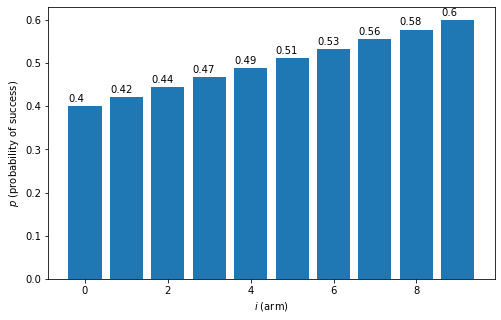

Probability of surviving over infinite horizon, given arm and budget:


,p,w
0,0.400,0.000
1,0.422,0.000
2,0.444,0.000
3,0.467,0.000
4,0.489,0.000
5,0.511,0.359
6,0.533,0.737
7,0.556,0.893
8,0.578,0.957
9,0.600,0.983


In [6]:
plt.rcParams['figure.figsize'] = (8, 5)

#number of arms and corresponding parameters
k = 10
p_arr = np.linspace(0.4, 0.6, k)

#BERNOULLI
arms = [BernoulliArm(p) for p in p_arr]

#initial budget
b_0 = k #15
omega = k #5

#domain support for rewards
d = Domain(r_min=-1.0, r_max=+1.0)

#each arm must be tried at least w times at beginning
w=1

#algorithms
algs = [
     FixedPolicy(k, w=w, fixed_i=0, label="Worst Arm"),
     FixedPolicy(k, w=w, fixed_i=k-1, label="Best Arm"),
     FixedPolicy(k, w=w, fixed_i=(k+1)//2, label="Worst Positive Arm"),
     FixedPolicy(k, w=w, fixed_i=(k-1)//2, label="Best Negative Arm"),
     RandomPolicy(k, w=w, label="Random Arm"),
     EmpiricalMeansPolicy(k, w=w, label="Empirical Means"),
     EmpiricalSumPolicy(k, w=w, label="Empirical Sum"),
     EpsilonGreedyPolicy(k, w=w, eps=0.1, label="Epsilon-Greedy (0.1)"), 
     #AlarmedEpsilonGreedyPolicy(k, w=w, eps=0.1, d=d, b_0=b_0, omega=omega),
     #SoftMaxPolicy(k, w=w),
     BernKLUCBPolicy(k, w=w, label="KL-UCB"),
     #AlarmedBernKLUCBPolicy(k, w=w, d=d, b_0=b_0, omega=omega, label="ST-KL-UCB"),
     #UCBalpha(k, alpha=1.0*ampl, lower=minr, amplitude=ampl),
     UCB1Policy(k, w=w, label="UCB"),
     #AlarmedUCBPolicy(k, w=w, d=d, b_0=b_0, omega=omega, label="ST-UCB"),
     #MaRaBPolicy(k, w=w, label="MaRaB"),
     #UCBV(k, w=w, lower=lower, amplitude=ampl),
     ThompsonPolicy(k, w=w, label="Thompson Sampling"),
     BayesUCBPolicy(k, w=w, label="Bayes-UCB"),
     #BanditGamblerPolicy(k, w=w, d=d, b_0=b_0, label="Gambler-Bayes"),  
     #BanditGamblerUCBPolicy(k, w=w, d=d, b_0=b_0, label="Gambler-Bayes-UCB"), 
     #PositiveGamblerUCB(k, w=w, d=d, b_0=b_0, label="Gambler-Positive")
     #BayesUCBGamblerPolicy(k, w=w, d=d, b_0=b_0, label="Bayes-UCB-Gambler"),
    ]

crits = [
    "Survival Episodes Rate", 
    "Survival Time (before ruin or end) (averaged over episodes)", 
    "Survival Time (std dev)", 
    "Cumulative Time on Negative Budget (averaged over episodes)", 
    "Cumulative Time on Negative Budget (std dev)", 
    "Cumulative Negative Budget (averaged over episodes)",
    "Cumulative Negative Budget (std dev)",
    "Cumulative Regret (averaged over episodes)",
    "Cumulative Regret (std dev)"
    ]
labels = ["Worst", "Oracle", "Random", "Empirical-Means", "$\epsilon$-Greedy 01", "$\epsilon$-Greedy 09", "ST-Eps", "SoftMax", "KL-UCB", "ST-KL-UCB", "UCB", "ST-UCB", "MaRaB", "Thompson", "Bayes-UCB", "Bayes-Gambler", "Bayes-UCB-Gambler"]
#labels = ["Empirical-Means", "$\epsilon$-Greedy", "KL-UCB", "UCB", "MaRaB", "Thompson", "Bayes-UCB", "Bayes-Gambler", "Bayes-UCB-Gambler"]
colors = ['r',               'tan',               'm',      'g',   'orange', 'c',        'b',         'k',            'k',                 'c', 'tan', 'pink', 'k', 'm']
styles = ['-',               '--',                '-',      '--', '-',     '--',       '-',           '--',           '-',                 ':', '-.', ':', '-']

#print(p_arr)
plt.ylim=(0.0, 1.0)
plt.bar(range(k), p_arr)
for i,p in enumerate(p_arr):
    plt.text(x=i-0.4, y=p+0.01, s=f"{p:0.2}")
plt.xlabel('$i$ (arm)')
plt.ylabel('$p$ (probability of success)')
plt.show()

def ruin_factor(p, b):
    return ((1-p)/p)**b

def ruin_prob(p, b):
    return ruin_factor(p, b) if p > 0.5 else 1.0

def surv_prob(p, b):
    return 1-ruin_prob(p, b)

def ruin_estimated_prob(p, x, y, b):
    return beta.cdf(0.5, x+1, y+1) + integral(lambda p, x, y, b : ((1-p)/p)**b * beta.pdf(p, x+1, y+1), 0.5, 1.0, (x, y, b))[0]

def surv_estimated_prob(p, x, y, b):
    b = max(1.0, self.b)
    return integral(lambda p, x, y, b : (1-((1-p)/p)**b) * beta.pdf(p, x+1, y+1), 0.5, 1.0, (x, y, b))[0]

print("Probability of surviving over infinite horizon, given arm and budget:") 
df = pd.DataFrame(([round(p, 3), round(surv_prob(p, b_0), 3)] for p in p_arr), columns = ["p", "w"])
display(df)

## Simulation Bernoulli : short-horizon

 - Several Repetitions 
 - Short Horizon

In [7]:
#time-horizon
h = 500

#repetitions
n = 15

M1 = SMAB(arms, algs, h, b_0, d=d, n=n)
M1.run(tqdm_leave=True)



  0%|          | 0/15 [00:00<?, ?it/s]

<ipython-input-3-1ace1cb803ee>:1047: RuntimeWarning: divide by zero encountered in true_divide
  fr_a = sr_a / SR[:,:,-1,np.newaxis]
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [9]:
#T = [49,99,149,199]
T = [49,299,499]

print('immortal precision (averaged over repetitions, does not stop on ruin)')
Y = M1.MF_a[:,M1.a_star]
df = pd.DataFrame(([Y[:,t] for t in T]), index=T, columns= [g.label for g in M1.G]).T
df = df.sort_values(by=T[::-1], ascending=False)
df = df.round(2)
display(df)

print('mortal budget (averaged over repetitions, zero if ruin)')
Y = M1.MRB
df = pd.DataFrame(([Y[:,t] for t in T]), index=T, columns= [g.label for g in M1.G]).T
df = df.sort_values(by=T[::-1], ascending=False)
df = df.round(2)
display(df)

print('survival rate')
Y = M1.MS
df = pd.DataFrame(([Y[:,t] for t in T]), index=T, columns= [g.label for g in M1.G]).T
df = df.sort_values(by=T[::-1], ascending=False)
df = df.round(2)
display(df)



immortal precision (averaged over repetitions, does not stop on ruin)


,49,299,499
Best Arm,0.82,0.97,0.98
Epsilon-Greedy (0.1),0.13,0.25,0.30
Empirical Sum,0.20,0.26,0.29
Bayes-UCB,0.13,0.22,0.24
Thompson Sampling,0.14,0.21,0.24
KL-UCB,0.10,0.13,0.15
UCB,0.11,0.14,0.15
Random Arm,0.09,0.10,0.10
Empirical Means,0.07,0.07,0.07
Worst Arm,0.02,0.00,0.00


mortal budget (averaged over repetitions, zero if ruin)


,49,299,499
Best Arm,19.60,73.87,112.00
Empirical Sum,15.20,41.87,66.67
Epsilon-Greedy (0.1),13.33,37.87,59.47
Empirical Means,12.93,38.80,57.60
Bayes-UCB,13.33,32.40,47.33
Thompson Sampling,12.53,28.67,42.13
KL-UCB,12.93,26.40,40.80
Worst Positive Arm,12.80,22.67,30.00
UCB,11.87,19.20,27.73
Random Arm,11.33,11.73,14.40


survival rate


,49,299,499
Best Arm,1.00,1.00,1.00
Empirical Sum,1.00,0.80,0.80
Thompson Sampling,1.00,0.73,0.73
Worst Positive Arm,0.93,0.73,0.73
Empirical Means,0.93,0.73,0.73
KL-UCB,0.93,0.73,0.73
Epsilon-Greedy (0.1),1.00,0.67,0.67
Bayes-UCB,1.00,0.67,0.67
UCB,0.93,0.67,0.60
Best Negative Arm,0.93,0.47,0.47


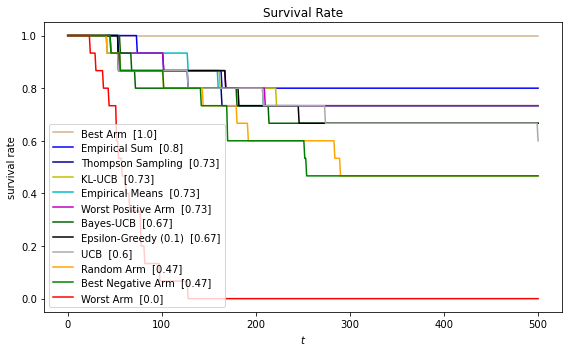

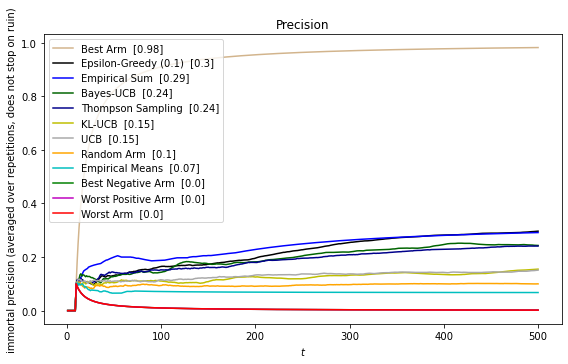

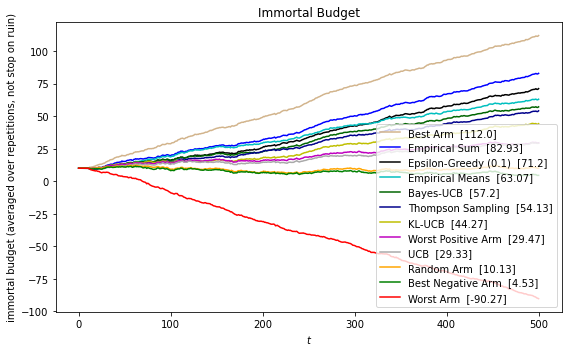

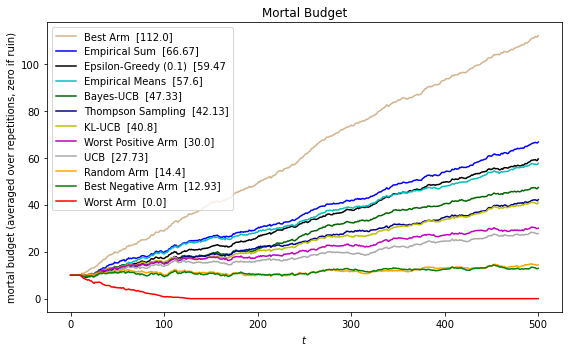

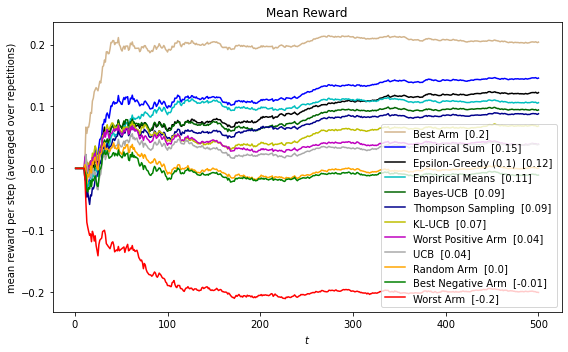

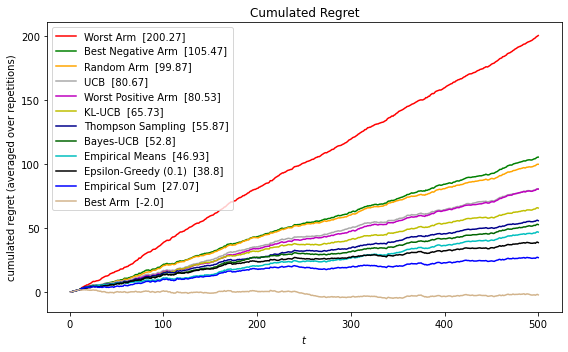

<ipython-input-3-1ace1cb803ee>:1117: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (Y=='precision') or (Y=='immortal_precision'):
<ipython-input-3-1ace1cb803ee>:1124: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif Y=='sum_reward':
<ipython-input-3-1ace1cb803ee>:1132: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif Y=='immortal_budget':
<ipython-input-3-1ace1cb803ee>:1140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif Y=='mortal_budget':
<ipython-input-3-1ace1cb803ee>:1148: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif Y=='penalized_budget':
<ipython-input-3-1ace1c

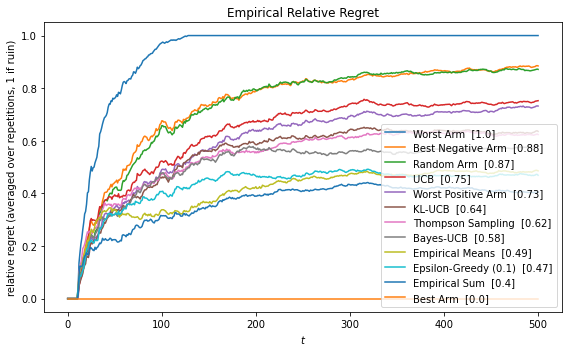

In [10]:
colors = ['r', 'tan', 'm', 'g', 'orange', 'c',  'b', 'k',  'y', 'darkgrey', 'darkblue', 'darkgreen']
styles = ['-', '--',  '-', '--', '-',     '--', '-', '--',  '-',    ':', '-.', ':', '-']

M1.plot('survival', filename='survival.pdf', figsize=(8,5), linecolors=colors)
M1.plot('precision', filename='precision.pdf', figsize=(8,5), linecolors=colors)
M1.plot('immortal_budget', filename='immortal_budget.pdf', figsize=(8,5), linecolors=colors)
M1.plot('mortal_budget', filename='mortal_budget.pdf', figsize=(8,5), linecolors=colors)
M1.plot('avg_reward', filename='avg_reward.pdf', figsize=(8,5), linecolors=colors)
M1.plot('sum_regret', filename='sum_regret.pdf', figsize=(8,5), linecolors=colors)

X = M1.T01
Z = np.reshape(np.repeat(0, M1.m), [M1.m, 1])
Y = np.block([Z, 1-M1.MRB/M1.MRB[1,:]])
M1.plot(Y, X=X, filename='relative_regret.pdf', figsize=(8,5), ylabel = 'relative regret (averaged over repetitions, 1 if ruin)', title="Empirical Relative Regret")
                

#import tikzplotlib
#tikzplotlib.save("test.tex")  #before show

if (export_files_from_colab):
    files.download('survival.pdf')
    files.download('precision.pdf')
    files.download('immortal_budget.pdf')
    files.download('mortal_budget.pdf')
    files.download('sum_regret.pdf')
    files.download('avg_regret.pdf')
    files.download('relative_regret.pdf')



## Simulation Bernoulli : long-horizon

 - Few Repetitions 
 - Long Horizon

In [ ]:
#time-horizon
h = 10000 
 
#repetitions
n = 100 #100

M2 = SMAB(arms, algs, h, d=d, n=n, b_0=b_0)
M2.run(tqdm_leave=True)

In [ ]:
M2.plot('survival')
M2.plot('precision')
M2.plot('sum_reward')
M2.plot('immortal_budget')
M2.plot('mortal_budget')
M2.plot('penalized_budget')
M2.plot('avg_reward')
M2.plot('sum_regret')
M2.plot('avg_regret')

if (export_files_from_colab):
  #files.download(date + '_survival_progression_h' + str(h) + '.pdf')
  pass
